# Using `load_ard` to load and cloud mask multiple satellite sensors

**Notebook currently compatible with both `NCI` and `DEA Sandbox` environments**

### Description
This notebook demonstrates how to use the `load_ard` function to import a time series of cloud-free observations from either multiple Landsat (i.e. Landsat 5, 7 and 8) or Sentinel 2 satellites (i.e. S2A and S2B). The function automatically applies cloud masking to the input data, and returns all available data from multiple sensors as a single combined `xarray.Dataset`.

Optionally, the function can be used to return only observations that contain a minimum proportion of good quality, non-cloudy or shadowed pixels. This can be used to extract visually appealing time series of observations that are not affected by cloud.

This notebook demonstrates how to use `load_ard` to:
* Load Landsat 5, 7 and 8 data into a single `xarray.Dataset`
* Optionally apply a cloud mask to the resulting data
* Filter resulting data to keep only cloud-free observations
* Load Sentinel 2A and 2B data into a single `xarray.Dataset`
* Optionally label resulting data with metadata indicating the satellite sensor the data came from


### Technical details
* **Products used:** `ga_ls5t_ard_3`, `ga_ls7e_ard_3`, `ga_ls8c_ard_3`, `s2a_ard_granule`, `s2b_ard_granule`
* **Analyses used:** concatenating sensors, cloud masking, cloud filtering, extracting time series data

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import sys

sys.path.append('../Scripts')
from dea_datahandling import load_ard


### Connect to the datacube


In [2]:
# Connect to datacube containg Sentinel 2 data
dc_sentinel2 = datacube.Datacube(app='Using_load_ard')

# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc_landsat = datacube.Datacube(app='Using_load_ard', env='c3-samples')
except:
    dc_landsat = datacube.Datacube(app='Using_load_ard')


## Loading multiple Landsat sensors
The `load_ard` function can be used to load a single, combined timeseries of cloud-masked data from multiple `DEA` products or satellite sensors. 
At its simplest, you can use the function similarly to `dc.load`, by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function ([see the `dc.load` documentation for all possible options](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)). 
The key difference from `dc.load` is that we also need to pass an existing `Datacube` object to the function using the `dc` parameter. 
This gives us flexibilty to load data from development or experimental datacubes.

By default, the function loads data from the three Landsat Collection 3 products (Landsat 5, 7 and 8): `['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3']`. 
In the result below, you can see that the function loaded 0 Landsat 5 observations, 11 Landsat 7 observations, and 12 Landsat 8 observations into a simple combined dataset containg 23 observations:

In [3]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc_landsat,
              x=(153.40, 153.45),
              y=(-28.85, -28.90),
              time=('2018-01', '2018-06'),
              measurements=['nbart_green'],
              output_crs='EPSG:3577',
              resolution=(-30, 30),
              group_by='solar_day')

# Print output data
print(ds)


Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 11 out of 11 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    Filtering to 12 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 23 observations 
<xarray.Dataset>
Dimensions:      (time: 23, x: 191, y: 212)
Coordinates:
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
  * time         (time) datetime64[ns] 2018-01-03T23:42:39.393181 ... 2018-06-28T23:41:33.464057
Data variables:
    nbart_green  (time, y, x) float64 625.0 640.0 595.0 ... 447.0 333.0 328.0
Attributes:
    crs:      EPSG:3577


We can achieve the same result using the `query` syntax:

In [4]:
# Create a reusable query
query = {
    'x': (153.40, 153.45),
    'y': (-28.85, -28.90),
    'time': ('2018-01', '2018-06'),
    'measurements': ['nbart_green'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc_landsat, **query)

# Print output data
print(ds)


Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 11 out of 11 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    Filtering to 12 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 23 observations 
<xarray.Dataset>
Dimensions:      (time: 23, x: 191, y: 212)
Coordinates:
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
  * time         (time) datetime64[ns] 2018-01-03T23:42:39.393181 ... 2018-06-28T23:41:33.464057
Data variables:
    nbart_green  (time, y, x) float64 625.0 640.0 595.0 ... 447.0 333.0 328.0
Attributes:
    crs:      EPSG:3577


### Cloud masking
By plotting a time slice from the data we loaded above, you can see an area of white pixels where clouds have been masked out and set to `NaN`:

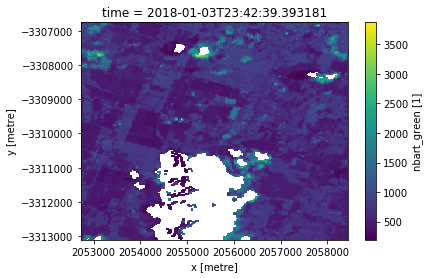

In [5]:
# Plot single observation
ds.isel(time=0).nbart_green.plot()


By default, `load_ard` applies a pixel quality mask to loaded data using the `fmask` band. 
The default mask is created based on `fmask` values `[1, 4, 5]` which will preserve non-cloudy or shadowed land, snow and water pixels, and set all invalid, cloudy or shadowy pixels to `NaN`. 
This can be customised using the `fmask_gooddata` parameter.
To deactive cloud masking completely, set `mask_pixel_quality=False`:

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 11 out of 11 observations
Loading ga_ls8c_ard_3 data
    Filtering to 12 out of 12 observations
Combining and sorting data
    Masking out invalid values
    Returning 23 observations 


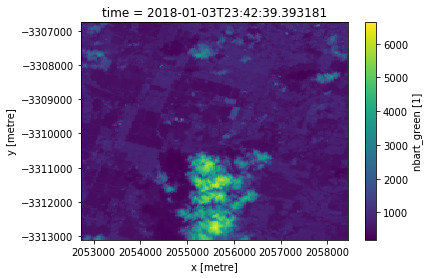

In [6]:
# Load available data with cloud masking deactivated
ds = load_ard(dc=dc_landsat, mask_pixel_quality=False, **query)

# Plot single observation
ds.isel(time=0).nbart_green.plot()


### Filtering to non-cloudy observations
In addition to masking out cloud, `load_ard` allows you to discard any satellite observation that contains less than a minimum proportion of good quality (e.g. non-cloudy) pixels.
This can be used to obtain a time series of only clear, cloud-free observations.

To discard all observations with less than `X`% good quality pixels, use the `min_gooddata` parameter. 
For example, `min_gooddata=0.99` will return only observations where less than 1% of pixels contain cloud, cloud shadow or other invalid data, resulting in a smaller number of clear, cloud free images being returned by the function:

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 0 out of 11 observations
Loading ga_ls8c_ard_3 data
    Filtering to 2 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 2 observations 


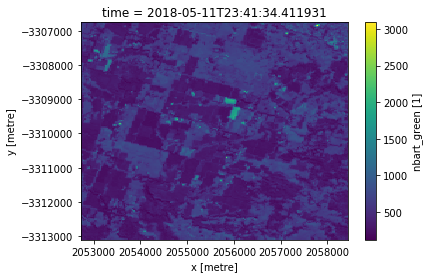

In [7]:
# Load available data filtered to 99% clear observations
ds = load_ard(dc=dc_landsat, min_gooddata=0.99, **query)

# Plot single observation
ds.isel(time=0).nbart_green.plot()


## Loading Sentinel 2 data
Data from the Sentinel 2A and 2B satellites can also be loaded using `load_ard`. 
To do this, we need to specify the two Sentinel 2 products (`['s2a_ard_granule', 's2b_ard_granule']`) in place of the default Landsat products:

In [8]:
# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc_sentinel2,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              **query)

# Print output data
print(ds)


Loading s2a_ard_granule data
    Filtering to 16 out of 16 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 17 observations
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 33 observations 
<xarray.Dataset>
Dimensions:      (time: 33, x: 191, y: 212)
Coordinates:
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
  * time         (time) datetime64[ns] 2018-01-01T23:52:39.027000 ... 2018-06-30T23:52:49.024000
Data variables:
    nbart_green  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:3577


Cloudy pixels are masked out by default from the resulting observations similarly to Landsat:

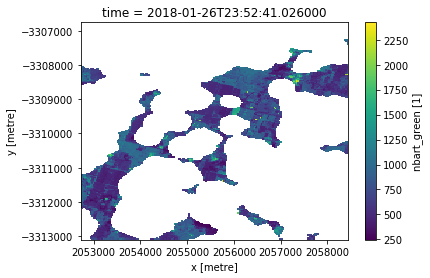

In [9]:
# Plot single observation
ds.isel(time=5).nbart_green.plot()


### Keeping track of sensor information
Because `load_ard` combines multiple sensors/products into a single `xarray.Dataset`, it can be important to keep track of what satellite made each observation. Setting `product_metadata=True` will add a new `product` variable to the output that labels each observation with its product name:

In [10]:
# Load available Sentinel 2 data, adding product metadata
ds = load_ard(dc=dc_sentinel2,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              product_metadata=True,
              **query)

# Print output data
print(ds)


Loading s2a_ard_granule data
    Filtering to 16 out of 16 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 17 observations
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 33 observations 
<xarray.Dataset>
Dimensions:      (time: 33, x: 191, y: 212)
Coordinates:
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
  * time         (time) datetime64[ns] 2018-01-01T23:52:39.027000 ... 2018-06-30T23:52:49.024000
Data variables:
    nbart_green  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    product      (time) <U15 's2b_ard_granule' ... 's2b_ard_granule'
Attributes:
    crs:      EPSG:3577


## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [11]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)